In [43]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 1: Create a directory for storing downloaded .nc files
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [4]:
# Step 2: Scrape the website for .nc file links
url = "https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/monthly/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [5]:
# Step 3: Find all links ending with .nc
nc_links = []
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.nc'):
        nc_links.append(url + href)  # Construct the full URL

In [6]:
# Step 4: Download the .nc files into the data directory
for nc_url in nc_links:
    filename = os.path.join(data_dir, nc_url.split('/')[-1])
    
    response = requests.get(nc_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f'Downloaded {filename}')

Downloaded data/seaice_conc_monthly_nh_197811_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197812_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197901_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197902_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197903_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197904_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197905_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197906_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197907_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197908_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197909_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197910_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197911_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197912_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198001_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198002_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_1

In [7]:
# Step 5: Combine the .nc files
nc_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.nc')]

# Prepare an empty list to store the modified datasets
datasets = []

# Define time points (adjust according to your actual time steps)
time_points = pd.date_range(start='1978-11-01', periods=len(nc_files), freq='MS')

# Loop through each file, open it, and assign a time coordinate
for i, nc_file in enumerate(nc_files):
    # Open the dataset
    ds = xr.open_dataset(nc_file)
    
    # Assign a time coordinate
    ds = ds.assign_coords(time=time_points[i])  # Assign the unique time coordinate
    ds = ds.expand_dims(dim='time')  # Expand to add time dimension of size 1
    
    # Append the modified dataset to the list
    datasets.append(ds)

In [8]:
# Step 6: Concatenate the datasets along the time dimension
combined_ds = xr.concat(datasets, dim='time')

In [9]:
# Step 7: Save the combined dataset to a new .nc file
output_filename = 'noaav4_nh_monthly_sic_1978_2024.nc'
combined_ds.to_netcdf(output_filename)
print(f'Saved combined dataset to {output_filename}')

Saved combined dataset to noaav4_nh_monthly_sic_1978_2024.nc


In [10]:
# Step 8: Check output of combined data file
ds_test = xr.open_dataset('noaav4_nh_monthly_sic_1978_2024.nc')
ds_test

<xarray.Dataset> Size: 2GB
Dimensions:                                 (time: 545, tdim: 1, y: 448, x: 304)
Coordinates:
  * time                                    (time) datetime64[ns] 4kB 1978-11...
    xgrid                                   (x) float32 1kB ...
    ygrid                                   (y) float32 2kB ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly                 (time, tdim, y, x) float32 297MB ...
    melt_onset_day_cdr_seaice_conc_monthly  (time, tdim, y, x) float32 297MB ...
    nsidc_bt_seaice_conc_monthly            (time, tdim, y, x) float32 297MB ...
    nsidc_nt_seaice_conc_monthly            (time, tdim, y, x) float32 297MB ...
    projection                              (time) |S1 545B ...
    qa_of_cdr_seaice_conc_monthly           (time, tdim, y, x) float32 297MB ...
    stdev_of_cdr_seaice_conc_monthly        (time, tdim, y, x) float32 297MB ...
Attributes: (12/41)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T16:08:07Z
    time_coverage_start:       1987-04-01T00:00:00Z
    time_coverage_end:         1987-04-30T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

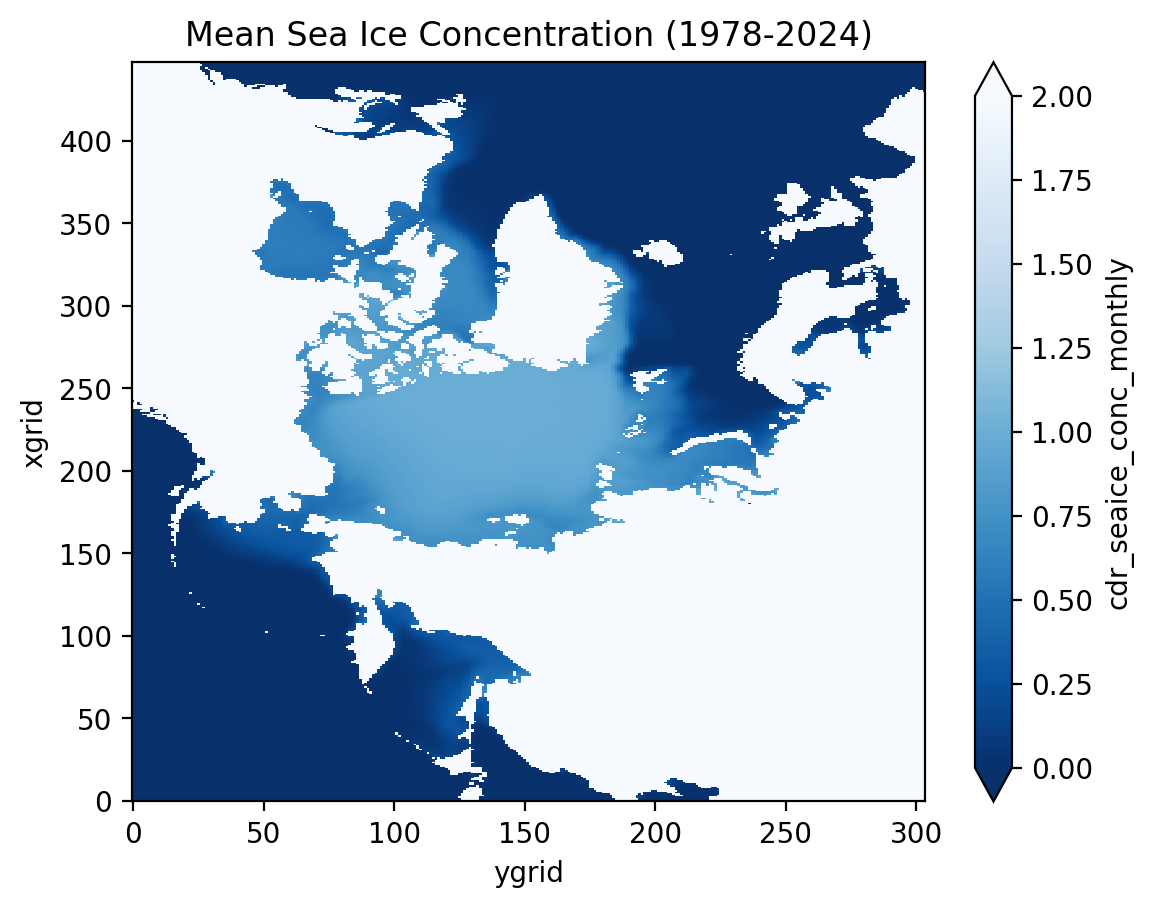

In [64]:
# Now we can analyze the data in this xarray dataset
# For example, we can calculate the mean sea ice concentration over time
mean_sic = ds_test['cdr_seaice_conc_monthly'].mean(dim='time')

# Plot the mean sea ice concentration with a color scale for sea ice concentration
plt.figure(dpi=200)
mean_sic.plot(cmap='Blues_r', vmin=0, vmax=2, extend='both')
plt.title('Mean Sea Ice Concentration (1978-2024)')
plt.xlabel('ygrid')
plt.ylabel('xgrid')
plt.show()


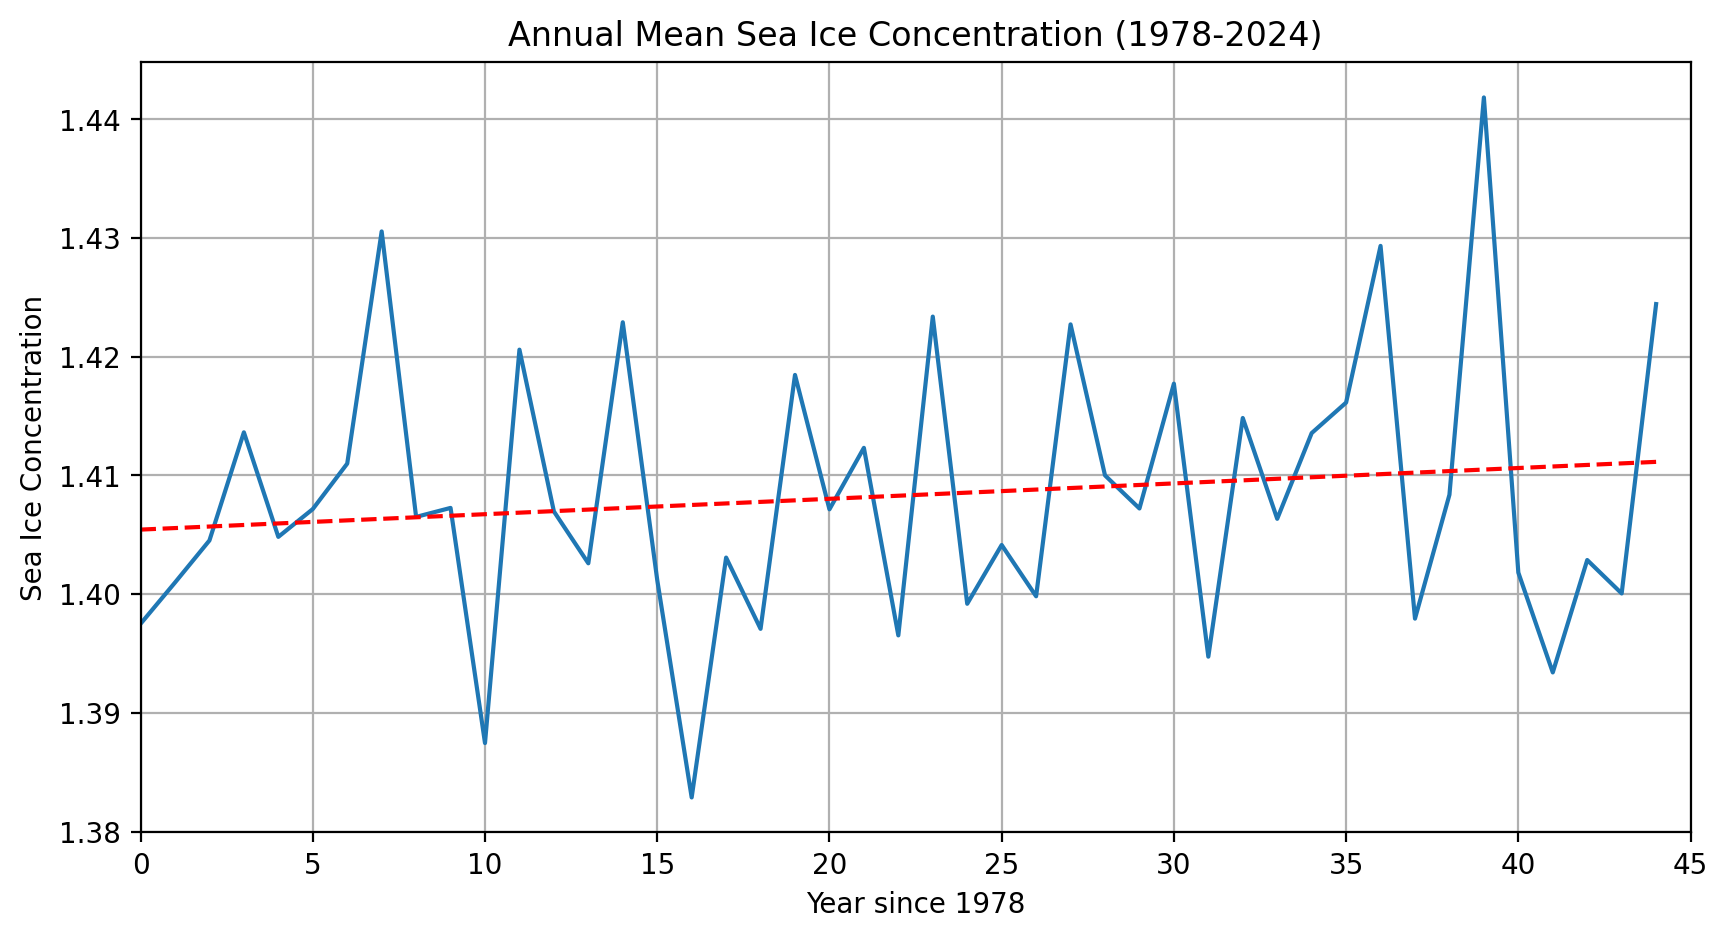

In [65]:
# We can also calculate the annual mean sea ice concentration
# Note we will adjust the data to plot complete years, so we cut off the last 5 months (2024)
annual_mean_sic = np.reshape(ds_test['cdr_seaice_conc_monthly'].mean(dim=['x', 'y'])[:-5], (45, 12))
annual_mean_sic = np.mean(annual_mean_sic, axis=1)

# Plot the annual mean sea ice concentration
plt.figure(dpi=200)
plt.plot(annual_mean_sic)
trend = np.polyfit(range(len(annual_mean_sic)), annual_mean_sic, 1)  # Plot a linear trend on top of the data
plt.plot(range(len(annual_mean_sic)), np.polyval(trend, range(len(annual_mean_sic))), 'r--')
plt.title('Annual Mean Sea Ice Concentration (1978-2024)')
plt.xlabel('Year since 1978')
plt.ylabel('Sea Ice Concentration')
plt.xlim(0, len(annual_mean_sic))
plt.grid()
plt.show()

